# Binning in 1D


The task is to generate histogram bin edges within the interval $[-1, 1]$ that best describes samples from an intractable target distributions on $[-1, 1]$. Target distribution samples are generated by pass unit Gaussian samples through a small multi-layer perceptron transformation with sinusoidal activation functions. 


### Table of contents
1. [Run LLM-innovation loop](#loop)
2. [Visualise KDE instances](#visualise)

In [2]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt


import template

<a id="1D"></a>
## 1. Example 1D challenge target distribution samples

In [18]:
seed = 12
rng_params = np.random.default_rng(seed)
rng_samps = np.random.default_rng(seed + 1)

num_samples = 2 ** 7
z = rng_samps.normal(size=(num_samples, 1))

x = template.generate_samples(rng_params, z)

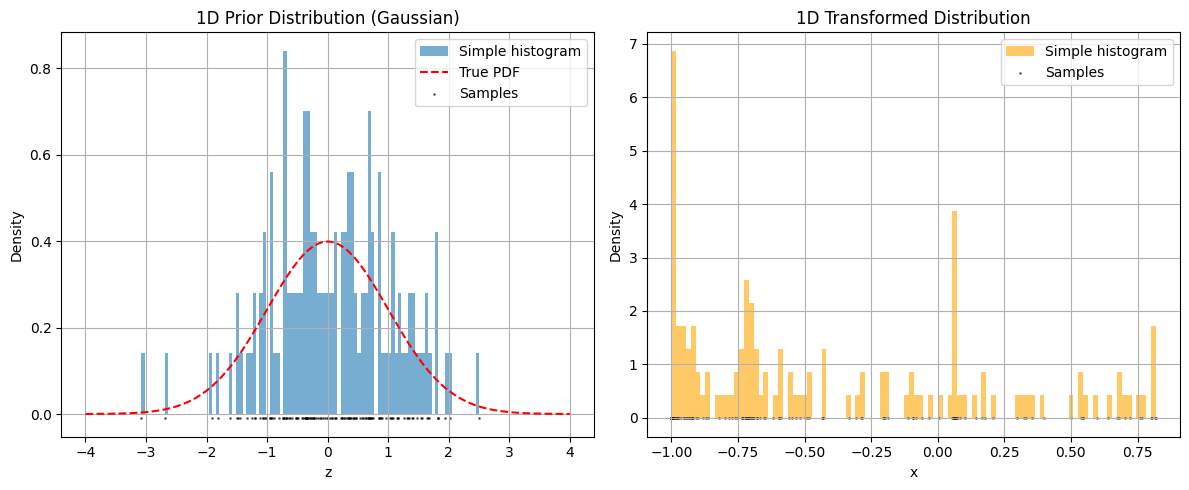

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


plt.figure(figsize=(12, 5))

# Prior
plt.subplot(1, 2, 1)
plt.hist(z, bins=100, density=True, alpha=0.6, label="Simple histogram")
x_vals = np.linspace(-4, 4, 200)
plt.plot(x_vals, norm.pdf(x_vals), 'r--', label="True PDF")
plt.scatter(z, np.full_like(z, -0.01), s=1, alpha=0.5, color="black", label="Samples")  # horizontal scatter below
plt.title("1D Prior Distribution (Gaussian)")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Transformed
plt.subplot(1, 2, 2)
plt.hist(x, bins=100, density=True, alpha=0.6, label="Simple histogram", color="orange")
plt.scatter(x, np.full_like(x, -0.01), s=1, alpha=0.5, color="black", label="Samples")  # horizontal scatter below
plt.title("1D Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 2. Example binning algorithms

In [7]:
def equal_quantile_binning(x_vals):
    """
    Binning based on equal empirical quantiles
    """
    num_bins = 8  # an arbitrarily chosen number of bins

    quantile_vals = np.linspace(0, 1, num_bins + 1)
    sort_inds = np.argsort(x_vals)

    # get indices corresponding to nearest to quantile values
    quantile_inds = [int(v * (len(sort_inds) - 1)) for v in quantile_vals]

    # convert from quantile to actual values
    bin_edges = np.sort(x_vals)[quantile_inds]
    bin_edges = [-1] + bin_edges.tolist()[1:-1] + [1]  # ensure edges cover the valid domain

    return bin_edges

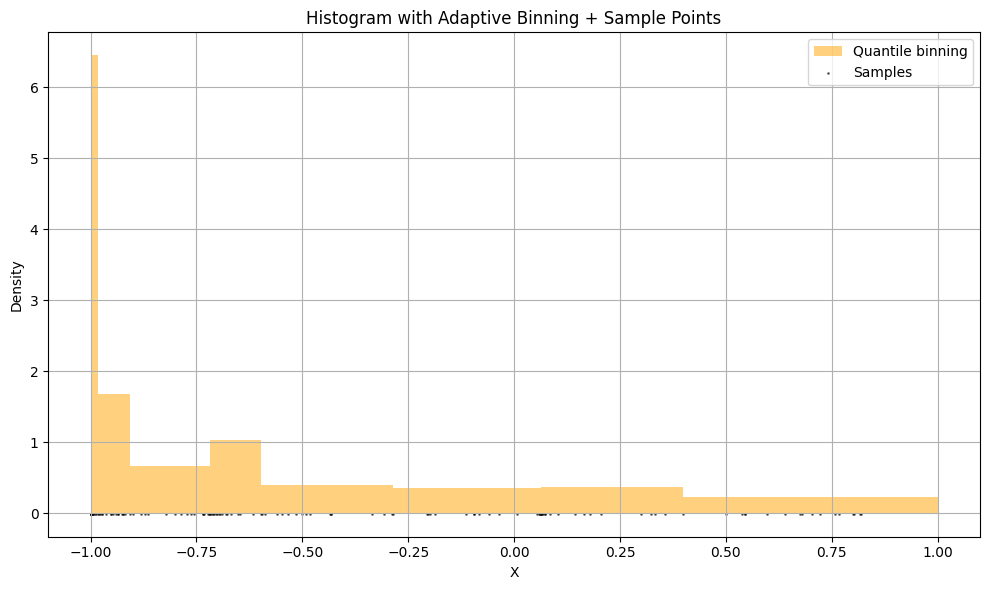

In [26]:
# Assuming x is [num_pts, 1]
x_flat = x[:, 0]

# quantile binning
bin_edges = equal_quantile_binning(x[:, 0])
adaptive_counts, _ = np.histogram(x_flat, bins=bin_edges)

# Plotting with horizontal scatter
plt.figure(figsize=(10, 6))
plt.hist(x_flat, bins=bin_edges, alpha=0.5, label='Quantile binning', color='orange', density=True)
plt.scatter(x_flat, np.full_like(x_flat, -0.01), s=1, alpha=0.5, color='black', label='Samples')  # horizontal points
plt.title('Histogram with Adaptive Binning + Sample Points')
plt.xlabel('X')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
def greedy_split(x_vals):
    """
    Greedy decision tree for splitting data into bins based on log likelihood metric
    """
    
    min_bin_width = 1e-3
    num_bins = 8  # an arbitrarily chosen number of bins

    def compute_log_likelihood(x, bins, counts):
        bin_indices = np.digitize(x, bins) - 1
        bin_widths = np.diff(bins)
        probs = counts / np.sum(counts)
        
        mask = (bin_indices >= 0) & (bin_indices < len(probs))
        log_probs = np.log(probs[bin_indices[mask]] / bin_widths[bin_indices[mask]])
        return np.sum(log_probs)

    x_vals = np.sort(x_vals)
    intervals = [(x_vals[0], x_vals[-1])]
    bins = [x_vals[0], x_vals[-1]]
    
    for _ in range(num_bins - 1):
        best_gain = -np.inf
        best_split = None
        best_new_bins = None
        
        for i, (a, b) in enumerate(intervals):
            candidates = x_vals[(x_vals > a) & (x_vals < b)]
            for s in candidates:
                if s - a < min_bin_width or b - s < min_bin_width:
                    continue
                test_bins = bins[:i+1] + [s] + bins[i+1:]
                test_counts, _ = np.histogram(x_vals, bins=test_bins)
                ll = compute_log_likelihood(x_vals, test_bins, test_counts)
                if ll > best_gain:
                    best_gain = ll
                    best_split = (i, s)
                    best_new_bins = test_bins
        
        if best_split is None:
            break
        bins = best_new_bins
        a, b = intervals.pop(best_split[0])
        s = best_split[1]
        intervals.insert(best_split[0], (s, b))
        intervals.insert(best_split[0], (a, s))

    return np.array(bins)


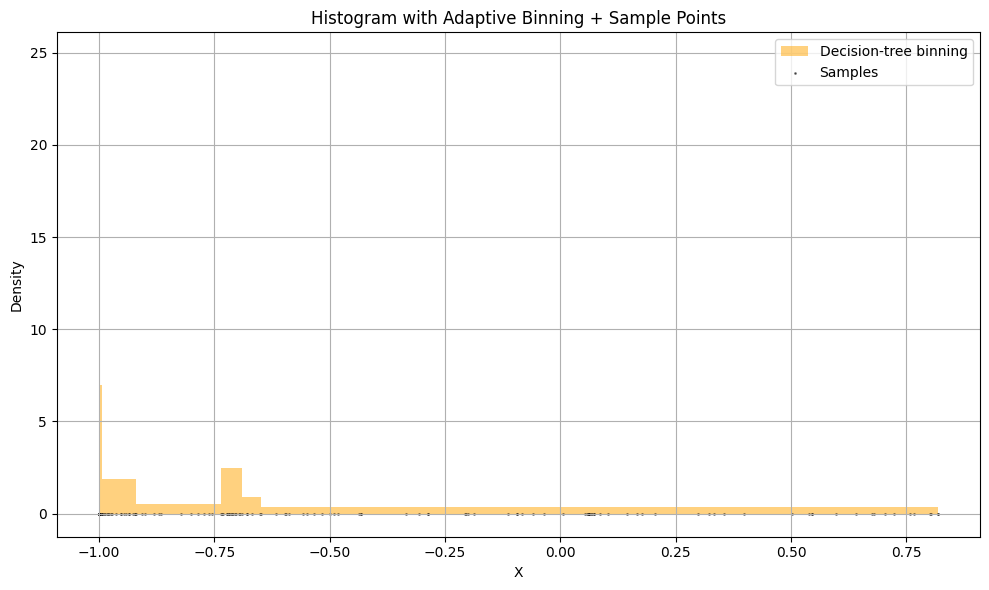

In [28]:
# Assuming x is [num_pts, 1]
x_flat = x[:, 0]

# Adaptive binning
adaptive_bins = greedy_split(x_flat)  # your custom function
adaptive_counts, _ = np.histogram(x_flat, bins=adaptive_bins)

# Plotting with horizontal scatter
plt.figure(figsize=(10, 6))
plt.hist(x_flat, bins=adaptive_bins, alpha=0.5, label='Decision-tree binning', color='orange', density=True)
plt.scatter(x_flat, np.full_like(x_flat, -0.01), s=1, alpha=0.5, color='black', label='Samples')  # horizontal points
plt.title('Histogram with Adaptive Binning + Sample Points')
plt.xlabel('X')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()